In [336]:
import os
import tensorflow as tf
from tensorflow import keras
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
import sys

def load_dataset(train_data_set,test_data_set):
    train_dataset = h5py.File(str(train_data_set), "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(str(test_data_set), "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
 
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [338]:
train_data_set = './datasets/train_catvnoncat.h5'
test_data_set = './datasets/test_catvnoncat.h5'

# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset(train_data_set,test_data_set)

y = 1. It's a cat picture.


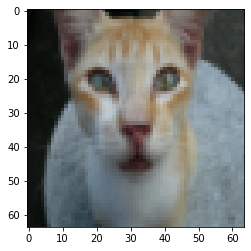

In [339]:
# Example of a picture
index = 11
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ". It's a " + classes[train_set_y[0, index]].decode("utf-8") + " picture.")

In [340]:
# Standardize data to have feature values between 0 and 1.
train_x = train_set_x_orig / 255.
test_x = test_set_x_orig / 255.

train_y = train_set_y.T
test_y = test_set_y.T

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_set_y.shape))

train_x's shape: (209, 64, 64, 3)
test_x's shape: (50, 64, 64, 3)
train_y's shape: (1, 209)


In [342]:
def train_cat_not_cat(train_x,train_y):
    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            print(logs.get('accuracy'))
            if logs.get('accuracy') > .999:
                self.model.stop_training = True
        def on_train_end(self, logs=None):
            # early stop at .999
            print("Reached trainig end returning model ")
    
    # creat the model 
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16,(3,3),strides=(1, 1), padding='valid',input_shape=(64,64,3)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1), padding='valid'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128 , activation = tf.nn.relu ),
        tf.keras.layers.Dense(1,  activation = tf.nn.sigmoid)
    ])
     # add the loss function and the optimizer for gradient descent 
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # model fitting
    history = model.fit(
        train_x,
        train_y,
        epochs=50,
        callbacks=[CustomCallback()],
    )

    # model fitting
    return  model

In [343]:
model = train_cat_not_cat(train_x,train_y)

Epoch 1/50
7/7 [==============================] - 1s 53ms/step - loss: 0.8014 - accuracy: 0.6260
0.6172248721122742
Epoch 2/50
7/7 [==============================] - 1s 74ms/step - loss: 0.5778 - accuracy: 0.6796
0.7033492922782898
Epoch 3/50
7/7 [==============================] - 0s 53ms/step - loss: 0.4933 - accuracy: 0.7052
0.7224880456924438
Epoch 4/50
7/7 [==============================] - 0s 52ms/step - loss: 0.4731 - accuracy: 0.7725
0.779904305934906
Epoch 5/50
7/7 [==============================] - 0s 53ms/step - loss: 0.4004 - accuracy: 0.8022
0.8229665160179138
Epoch 6/50
7/7 [==============================] - 0s 67ms/step - loss: 0.3322 - accuracy: 0.8660
0.8612440228462219
Epoch 7/50
7/7 [==============================] - 0s 59ms/step - loss: 0.3488 - accuracy: 0.8128
0.8229665160179138
Epoch 8/50
7/7 [==============================] - 0s 61ms/step - loss: 0.3207 - accuracy: 0.8903
0.8947368264198303
Epoch 9/50
7/7 [==============================] - 0s 58ms/step - loss: 0.

In [344]:
test_loss, test_acc = model.evaluate(test_x,test_y, verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 0s - loss: 1.2021 - accuracy: 0.6400

Test accuracy: 0.6399999856948853


In [345]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

cat 


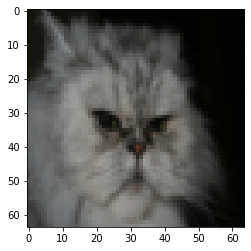

In [346]:
# Example of a picture
index = 12
plt.imshow(test_x[index])
predictions = model.predict(test_x)
label = np.argmax(predictions[index])
class_names = ['cat ', 'Not cat']
print(class_names[label])

In [347]:
def load_image(filename):
	# load the image
    img = cv2.imread(filename)
    # resize the image 
    img = cv2.resize(img,(64,64))
	# convert to array
    img = np.array(img)
    # reshape into a single sample with 1 channel
    if(type(img) == type(None)):
        pass
    else:
        image = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
    # prepare pixel data
    img = img.astype('float32')
    # normalize the data 
    img = img / 255.0
    # return the image 
    return img

In [348]:
# predict from unknown images 
class_names = ['cat', 'Not cat']

def predict(img):
    # reshape the image
    img = img.reshape(1,64,64,3)
    # predict the image lavel 
    label = model.predict(img)
    # return the prediction 
    return class_names[np.argmax(label)]

cat


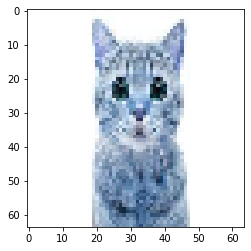

In [349]:
img = load_image('/Users/prashunjaveri/Desktop/cat.jpeg')
plt.imshow(img)
print(predict(img))

In [350]:
# save the model 
def save_model(path):
    #save the model to path 
    model.save(path)

In [351]:
def load_model(path):
    #load the model 
    new_model = tf.keras.models.load_model(path)
    # Check its architecture
    new_model.summary()
    #return the model
    return new_model

In [352]:
os.mkdir('models')

FileExistsError: [Errno 17] File exists: 'models'

In [353]:
save_model('./models/binary_image_classifier')

INFO:tensorflow:Assets written to: ./models/binary_image_classifier/assets


In [315]:
model = load_model('./models/binary_image_classifier')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [354]:
def predict(img):
    # reshape the image
    img = img.reshape(1,64,64,3)
    # predict the image lavel 
    label = model.predict(img)
    # return the prediction 
    return class_names[np.argmax(label)]

In [355]:
img = load_image('/Users/prashunjaveri/Desktop/cat.jpeg')
print(predict(img))

cat


In [356]:
def evaluate(root_dir):
    predictions = []
    predicted_labels = []
    file_names = [] 
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if f.split('.')[1] == 'jpeg' or f.split('.')[1] == 'png' :
                path = os.path.join(root_dir,f)
                file_names.append(f)
                img = load_image(path)
                label = predict(img)
                predictions.append(class_names.index(label))
                predicted_labels.append(label)
    return (file_names , predictions , predicted_labels )

In [387]:
import pandas as pd 


def get_expected_labels(predictions):
    labels = []
    for p in predictions:
        labels.append(class_names[p])
    return  labels

def create_report(path, expected):
    predictions  = evaluate(path)
    expected = expected['predictions'].values
    expected_labels = get_expected_labels(expected)
    df = pd.DataFrame({
        'file':predictions[0] ,
        'predictions':predictions[1],
        'predicted_labels':predictions[2],
        'expected':expected,
        'expected_labels':expected_labels
        })

    total_number_of_files  = len(predictions[0])
    all_data = df.to_json(orient="split")
    
    all_df = df 

    comparison_column = np.where(all_df["predictions"] == all_df["expected"], True, False)
    all_df["equal"] = comparison_column

    df = all_df[all_df['equal'] == False]
    wrongly_identified_data = df.to_json(orient="split")

    df = all_df[all_df['equal'] == True]
    correctly_identified_data = df.to_json(orient="split")

    percentage_error = 100 - (( total_number_of_files - no_of_wrongly_identified_files ) / total_number_of_files ) * 100
    return (all_data,wrongly_identified_data,correctly_identified_data,percentage_error)

In [388]:
import json 

df = pd.DataFrame({ 'predictions': [1,0,0,0,1,0]  })

all_rows,wrongly_identified,correctly_identified_data,percentage_error = create_report('/Users/prashunjaveri/Desktop/eval', df)

def append_all_rows_to_result(all_rows,result):
    data = json.loads(all_rows)['data']
    columns = json.loads(all_rows)['columns']
    row_map = {}
    rows = [] 
    for row in data:
        for index,item in enumerate(row) :
            row_map[columns[index]] = item 
        rows.append(row_map)       
    result['all'] = rows
    return result 

def append_rows_with_errors_result(wrongly_identified,result):
    data = json.loads(wrongly_identified)['data']
    columns = json.loads(wrongly_identified)['columns']
    row_map = {}
    rows = [] 
    for row in data:
        for index,item in enumerate(row[0:len(row)-1]) :
            row_map[columns[index]] = item 
        rows.append(row_map)       
    result['errors'] = rows
    return result 

def append_rows_with_correct_result(correctly_identified_data,result):
    data = json.loads(correctly_identified_data)['data']
    columns = json.loads(correctly_identified_data)['columns']
    row_map = {}
    rows = [] 
    for row in data:
        for index,item in enumerate(row[0:len(row)-1]) :
            row_map[columns[index]] = item 
        rows.append(row_map)       
    result['correct'] = rows
    return result 

result = {}

def generate_report(result = {}):
    result = append_all_rows_to_result(all_rows,result)
    result = append_rows_with_errors_result(wrongly_identified,result)
    result = append_rows_with_correct_result(correctly_identified_data,result)
    result['percentage_error'] = percentage_error
    return result 

In [389]:
result = json.dumps(generate_report({}), indent=4, sort_keys=True)
print(result)

{
    "all": [
        {
            "expected": 0,
            "expected_labels": "cat",
            "file": "cat_4.jpeg",
            "predicted_labels": "cat",
            "predictions": 0
        },
        {
            "expected": 0,
            "expected_labels": "cat",
            "file": "cat_4.jpeg",
            "predicted_labels": "cat",
            "predictions": 0
        },
        {
            "expected": 0,
            "expected_labels": "cat",
            "file": "cat_4.jpeg",
            "predicted_labels": "cat",
            "predictions": 0
        },
        {
            "expected": 0,
            "expected_labels": "cat",
            "file": "cat_4.jpeg",
            "predicted_labels": "cat",
            "predictions": 0
        },
        {
            "expected": 0,
            "expected_labels": "cat",
            "file": "cat_4.jpeg",
            "predicted_labels": "cat",
            "predictions": 0
        },
        {
            "expected": 0,
        